# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
##mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls /content/drive

'My Drive'


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x59032000 @  0x7f7ffafc72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:

import requests


In [0]:
url = 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'

target_path = 'flowers_train.zip'

response = requests.get(url, stream=True)
handle = open(target_path, "wb")
for chunk in response.iter_content(chunk_size=512):
  if chunk: #filter out keep-alive new chunks
    handle.write(chunk)
    
handle.close()

!unzip flowers_train.zip

Archive:  flowers_train.zip
replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Imports here

#imports for image processing
import PIL
from PIL import Image


#import matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#import seaborn
import seaborn as sns

#import helper.py
import helper

#imports from numpy
import numpy as np

#imports from pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#imports from torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

#train on GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

test_dir = '/content/drive/My Drive/Flower_test/flower_data_original_test'

In [0]:
#basic format of dataloader
transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                transforms.Normalize((.485,.456,.406),(.229,.224,.225))])

#dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

#loader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [0]:
#transforms
#interpolation = PIL.Image.BILINEAR
#transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(1.0, 1.5), shear=None, resample=PIL.Image.BILINEAR, fillcolor=0),

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.Resize(256), 
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                     transforms.Normalize((.485,.456,.406),(.229,.224,.225))]) 

test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((.485,.456,.406),(.229,.224,.225))])

#datasets


train_data = datasets.ImageFolder(train_dir, transform=train_transform)

test_data = datasets.ImageFolder(valid_dir, transform=test_transform)

true_test_data = datasets.ImageFolder(test_dir, transform = test_transform)

#dataloaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

true_test_loader = torch.utils.data.DataLoader(true_test_data, batch_size = 16)



1


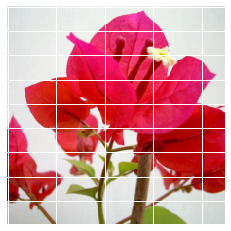

In [0]:
# Run this to test your data loader
images, labels = next(iter(dataloader))

figax = labels[0].numpy() 
print(figax)
helper.imshow(images[0])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    

print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# TODO: Build and train your network

#Step 1: Build the network: recommendation resnet152
model = models.resnet152(pretrained = True)

print(model)

for param in model.parameters():
  param.requires_grad = False
  

torch.manual_seed(42)

classifier = nn.Sequential(nn.Linear(2048, 102))


model.fc = classifier





Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 89192467.81it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
#specify loss criterion and optimizer criterion



#load model: after training for manual adjustment. Change lr from .01 to .001. load path from file directory first
model.load_state_dict(torch.load('/content/drive/My Drive/UdacityPytorchModelSaves/augmented_model.pth'))

#model.load_state_dict(torch.load(path))

### for resnet##########
##unfreezing of layers#################

for param in model.layer1.parameters():
  param.requires_grad = True

for param in model.layer2.parameters():
   param.requires_grad = True
  
for param in model.layer3.parameters():
   param.requires_grad = True
  
for param in model.layer4.parameters():
   param.requires_grad = True
    
for param in model.avgpool.parameters():
   param.requires_grad = True
  
for param in model.fc.parameters():
   param.requires_grad = True
  


#loss criterion:
criterion = nn.CrossEntropyLoss()


#optimizer of choice
optimizer = optim.Adam([{'params': model.layer1.parameters(), 'lr': 1e-5},
                        {'params': model.layer2.parameters(), 'lr': 1e-5},
                        {'params': model.layer3.parameters(), 'lr': 1e-5},
                        {'params': model.layer4.parameters(), 'lr': 1e-5},
                        {'params': model.avgpool.parameters(), 'lr': 1e-5},
                        {'params': model.fc.parameters()}],
                       lr=1e-4)

#scheduler to modify learning rate

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose = True)

#move model to GPU
model.to(device)

#move tensors to GPU if available
if train_on_gpu:
    model.cuda()

In [0]:
def lr_find(model, optimizer, criterion, train_loader, valid_loader=None, device='cpu', end_lr=10, num_iters=100,
            step_mode="exp", smoothing_factor=0.1, divergence_threshold=5, threshold_mode="rel", live_plot=False):
    """Performs the learning rate range test.
    
    Arguments:
        train_loader (torch.utils.data.DataLoader): the training set data laoder.
        valid_loader (torch.utils.data.DataLoader, optional): if `None` the range test
            will only use the training loss. When given a data loader, the model is
            evaluated after each iteration on that dataset and the evaluation loss
            is used. Note that in this mode the test takes significantly longer but
            generally produces more precise results. Default: None.
        end_lr (float, optional): the maximum learning rate to test. Default: 10.
        num_iters (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        step_mode (str, optional): one of the available learning rate policies,
            linear or exponential ("linear", "exp"). Default: "exp".
        smoothing_factor (float, optional): the loss smoothing factor within the [0, 1[
            interval. Disabled if set to 0, otherwise the loss is smoothed using
            exponential smoothing. Default: 0.05.
        divergence_threshold (int, optional): the test is stopped when the loss surpasses the
            threshold:  diverge_th * best_loss. Default: 5.
        threshold_mode (str, optional): one of ("rel", "abs").
            If "rel", the threshold will be the best_loss * `divergence_threshold`.
            If "abs", the threshold will be the best_loss + `divergence_threshold`. Default: "rel"
        live_plot (bool, optional): whether to display a dynamic plot that shows the progress
            in real time. If `valid_loader` is given, both losses are plotted. Default: True.
    """
    history = {"lr": [], "loss": []}
    
    if not isinstance(num_iters, int):
        raise TypeError("expected int value for num_iter, but got {}".format(type(num_iters)))
    if num_iters < 1:
        return history
    
    if not isinstance(threshold_mode, str):
        raise TypeError('expected str value for threshold_mode, but got {}'.format(type(threshold_mode)))
    if threshold_mode.lower() not in ("abs", "rel"):
        raise ValueError('expected one of (rel, abs), got {}'.format(threshold_mode))
    threshold_mode = threshold_mode.lower()
    
    if not isinstance(step_mode, str):
        raise TypeError('expected str value for step_mode, but got {}'.format(type(step_mode)))
        
    if smoothing_factor < 0 or smoothing_factor > 1:
        raise ValueError("smoothing_factor is outside the range [0, 1]")
        
    if step_mode.lower() in ("exp", "exponential"):
        ratio = end_lr / optimizer.param_groups[0]['lr']
        gamma = ratio ** (1 / max(num_iters - 1, 1))
        lr_schedule = lr_scheduler.ExponentialLR(optimizer, gamma)
    elif step_mode.lower() in ("lin", "linear"):
        step_size = (end_lr - optimizer.param_groups[0]['lr']) / max(num_iters - 1, 1)
        lr_schedule = lr_scheduler.LambdaLR(optimizer, (lambda epoch: 1 + (step_size * epoch)))
    else:
        raise ValueError("expected one of (exp, linear), got {}".format(step_mode))
    
    init_model_state = deepcopy(model.state_dict())
    init_optimizer_state = deepcopy(optimizer.state_dict())
    
    lr_schedule.step(0)
    lr = lr_schedule.get_lr()[0]
    loss = np.inf
    stat_format = "Learning Rate = {:.2e}, Loss = {:.4f}"
#     stat_tracker = {"Learning Rate": lr_schedule.get_lr()[0], "Loss": np.inf}
    
    model.train()
    iterator = tqdm(iterable=range(num_iters), desc="Iterating ...", unit="epoch")
    iterator.set_postfix_str(stat_format.format(Decimal(lr), loss), refresh=True)
    try:
        if live_plot:
            %matplotlib notebook
            fig, ax = plt.subplots(figsize=(13, 6), facecolor=fig_bg_color)
            ax.set_facecolor(plot_bg_color)
            ax.grid(True)
            if step_mode.lower() in ("exp", "exponential"):
                ax.set_xscale("log")
            else:
                ax.set_xscale("linear")
            ax.set_title("LR Finder", fontsize=fontsize)
            ax.set_xlabel("Learning rate", fontsize=fontsize)
            ax.set_ylabel("Loss", fontsize=fontsize)
            if valid_loader:
                train_losses = []
            
        for iteration in iterator:
            inputs, labels = next(iter(train_loader))
            inputs, labels = inputs.to(device), labels.to(device)

            lr_schedule.step(iteration)

            optimizer.zero_grad()
            
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

            if valid_loader:
                if live_plot:
                    if iteration == 0:
                        train_losses.append(loss.item())
                    else:
                        train_losses.append(smoothing_factor * loss.item() + (1 - smoothing_factor) * train_losses[-1])
                if iteration != 0:
                    valid_iterator.leave = False
                    valid_iterator.close()
                valid_iterator = tqdm(iterable=valid_loader, desc="Validation Iterations", unit="epoch")
                
                model.eval()
                loss = 0
                total_instances = 0
                with torch.no_grad():
                    for inputs, labels in valid_iterator:
                        inputs, labels = inputs.to(device), labels.to(device)
                        loss += criterion(model(inputs), labels).item() * inputs.size(0)
                        total_instances += inputs.size(0)
                        iterator.refresh()
                loss /= total_instances
                model.train()
            else:
                loss = loss.item()

            history['lr'].append(lr_schedule.get_lr()[0])
            lr = history['lr'][-1]

            if iteration == 0:
                best_loss = loss
            else:
                if smoothing_factor > 0:
                    loss = smoothing_factor * loss + (1 - smoothing_factor) * history["loss"][-1]
                if loss < best_loss:
                    best_loss = loss

            history["loss"].append(loss)

            iterator.set_postfix_str(stat_format.format(Decimal(lr), loss), refresh=False)
            
            if live_plot:
                if iteration == 1:
                    if valid_loader:
                        ax.plot(history['lr'], train_losses, color='blue', label='train')
                        ax.plot(history['lr'], history['loss'], color='orange', label='valid')
                        ax.legend()
                    else:
                        ax.plot(history['lr'], history['loss'], color='blue')
                    fig.canvas.draw()
                elif iteration > 1:
                    if valid_loader:
                        ax.lines[0].set_xdata(history['lr'])
                        ax.lines[0].set_ydata(train_losses)
                        ax.lines[1].set_xdata(history['lr'])
                        ax.lines[1].set_ydata(history['loss'])
                    else:
                        ax.lines[0].set_xdata(history['lr'])
                        ax.lines[0].set_ydata(history['loss'])
                    ax.relim()
                    ax.autoscale_view()
                    fig.canvas.draw()

            if threshold_mode == "rel" and loss > divergence_threshold * best_loss:
                print("Stopping early, the loss has diverged.")
                break
            elif loss > divergence_threshold + best_loss:
                print("Stopping early, the loss has diverged.")
                break
                
    except KeyboardInterrupt:
        pass
        
    %matplotlib inline
    model.load_state_dict(init_model_state)
    optimizer.load_state_dict(init_optimizer_state)
    return history
    
lr_finder(model,optimizer, scheduler2, train_loader )

In [0]:
epochs = 30
steps = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(epochs):
  #comment scheduler step below if using cosineannealing
  
  #scheduler1.step()
  train_loss = 0

  model.train()
  train_losses = []
  
  for inputs, labels in train_loader:
    #scheduler.step()
      
    inputs, labels = inputs.to(device), labels.to(device) 

    optimizer.zero_grad()

    logps = model(inputs)

    loss = criterion(logps, labels)
    loss.backward()

    optimizer.step() 

    train_loss += loss.item()
    
    
        
  #print('Reset scheduler')
  #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
           
    ### Validation loop
  with torch.no_grad():
    model.eval()
    accuracy = 0
    valid_loss = 0
    valid_losses = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model(inputs)

        loss = criterion(output, labels)

        valid_loss += loss.item()
        
        



        ps = torch.exp(output)
        top_ps, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

       
    scheduler2.step(valid_loss)   
        
    print("Epoch {}/{}.. ".format(epoch+1, epochs),
            "Training loss: {:.3f}.. ".format(train_loss / len(train_loader)),  
            "Validation loss: {:.3f}..".format(valid_loss / len(test_loader)),
            "Validation accuracy: {:.3f}..".format(accuracy / len(test_loader)))
    
   
  model.train()
  
  
  
  # save model if validation loss has decreased
  if valid_loss/len(test_loader) <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss/len(test_loader)))
      
      
      #model_save_name = 'augmented_model.pth'
      
      
      valid_loss_min = valid_loss/len(test_loader)
      
       #model_save_name = 'augmented_model.pth'
      path = "/content/drive/My Drive/UdacityPytorchModelSaves/augmented_model1.pth"
      torch.save(model.state_dict(), path)
      
      model.epochs = epochs
      model.accuracy = accuracy
      model.train_loss = train_loss
      model.valid_loss = valid_loss
      model.cat_to_name = cat_to_name
      model.class_to_idx = train_data.class_to_idx

      model.scheduler = scheduler2
      model.optimizer = optimizer
      model.criterion = criterion

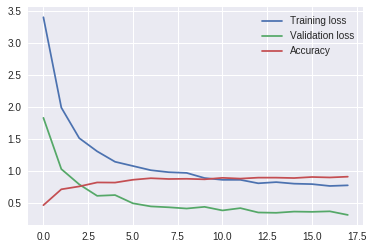

In [0]:
#Plot train and valid losses


plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.plot(accuracy, label = 'Accuracy') 

plt.legend(frameon = False)

In [0]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for data, target in true_test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(true_test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.059573

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 100% ( 3/ 3)
Test Accuracy of     2: 100% ( 8/ 8)
Test Accuracy of     3: 100% ( 4/ 4)
Test Accuracy of     4: 100% ( 6/ 6)
Test Accuracy of     5: 100% ( 9/ 9)
Test Accuracy of     6: 100% ( 9/ 9)
Test Accuracy of     7: 100% ( 6/ 6)
Test Accuracy of     8: 100% ( 3/ 3)
Test Accuracy of     9: 100% ( 4/ 4)

Test Accuracy (Overall): 99% (812/819)


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:


checkpoint_path = "/content/drive/My Drive/UdacityPytorchModelSaves/augmented_model2.pth"
  
model.to(device)
                  
checkpoint = {'model': model,
              'epochs': model.epochs,            
              'accuracy': model.accuracy,
              'train_loss': model.train_loss,
              'valid_loss': model.valid_loss,
              'cat_to_name': model.cat_to_name,
              'state_dict': model.state_dict(),            
              'scheduler': model.scheduler.state_dict(),
              'optimizer': model.optimizer.state_dict(),
              'criterion': model.criterion.state_dict(),                                              
              'class_to_idx': model.class_to_idx}
     
torch.save(checkpoint, checkpoint_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model 

path = "/content/drive/My Drive/UdacityPytorchModelSaves/augmented_model2.pth"

def load_checkpoint(checkpoint_path):
    
    checkpoint = torch.load(checkpoint_path) 
    
    
    
    model = checkpoint['model']
    model.epochs = checkpoint['epochs']
    model.accuracy = checkpoint['accuracy']
    model.train_loss = checkpoint['train_loss']
    model.valid_loss = checkpoint['valid_loss']    
    model.cat_to_name = checkpoint['cat_to_name']  
    model.load_state_dict(checkpoint['state_dict'])
    
    model.scheduler.load_state_dict(checkpoint['scheduler'])
    model.optimizer.load_state_dict(checkpoint['optimizer'])                       
    model.criterion.load_state_dict(checkpoint['criterion'])  
    
    model.class_to_idx = checkpoint['class_to_idx']    
    
    model.eval() 
    
    return model
  
model = load_checkpoint(path)

 


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
type(images[0])

(images[0])

tensor([[[-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.0837, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1179]],

        [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         ...,
         [-1.4580, -1.5105, -1.5105,  ..., -1.2304, -1.2654, -1.2479],
         [-1.5280, -1.5805, -1.6331,  ..., -1.3004, -1.3179, -1.3179],
         [-1.5630, -1.6331, -1.6856,  ..., -1.3704, -1.3880, -1.3880]],

        [[-1.7870, -1.7870, -1.7870,  ..., -1.7870, -1.7870, -1.7870],
         [-1.7870, -1.7870, -1.7870,  ..., -1

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    img = Image.open(image)
    img_loader = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([.485, .456, .406],
                                                        [.229, .224, .225])])
    img = img_loader(img)
    img = np.array(img)
    return img
    
x = process_image('flower_data/valid/1/image_06739.jpg')

x

array([[[-2.1007793, -2.1007793, -2.1007793, ..., -2.1007793,
         -2.1007793, -2.1007793],
        [-2.1007793, -2.1007793, -2.1007793, ..., -2.1007793,
         -2.1007793, -2.1007793],
        [-2.1007793, -2.1007793, -2.1007793, ..., -2.1007793,
         -2.1007793, -2.1007793],
        ...,
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.0836544,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.1007793,
         -2.117904 , -2.117904 ]],

       [[-2.0182073, -2.0182073, -2.0182073, ..., -2.0182073,
         -2.0182073, -2.0182073],
        [-2.0182073, -2.0182073, -2.0182073, ..., -2.0182073,
         -2.0182073, -2.0182073],
        [-2.0182073, -2.0182073, -2.0182073, ..., -2.0182073,
         -2.0182073, -2.0182073],
        ...,
        [-1.457983 , -1.5105042, -1.5105042, ..., -1.230392 ,
         -1.265406 , -1.247899 ],
        [-1.

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

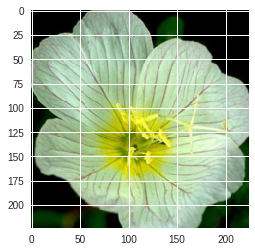

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
  
imshow(torch.from_numpy(x))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img = process_image('flower_data/valid/1/image_06739.jpg')


img = torch.from_numpy(img)

img = img.to(device)

type(img)

torch.Tensor

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    
    img = process_image(image_path)
    
    img = torch.from_numpy(img).unsqueeze(0)
    
    img = img.cuda()
   
   
    
    #calculate class probabilities of top 5 classes
    ps = torch.exp(model.forward(img))
    
    top_p, top_class = ps.topk(topk) 
    
    top_p, top_class = top_p.cpu().detach().numpy().tolist()[0]  , top_class.cpu().detach().numpy().tolist()[0] 
    
    #class indexing code taken from medium article by josh bernhard
    idx_to_class =  {y:x for x,y in model.class_to_idx.items()}
    classes = [idx_to_class[ii] for ii in top_class]
    flowers = [cat_to_name[idx_to_class[ii]] for ii in top_class]

    return top_p, top_class, flowers
    
    #return top_p, top_class
  
probs, classes, flowers = predict('flower_data/valid/1/image_06739.jpg', model)

#Had to go in a circle here to get softmax applied

probs = np.asarray(probs)

probs = torch.from_numpy(probs)

probs = F.softmax(probs)

probs = probs.numpy()

print(probs)


[1. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
image_path = 'flower_data/valid/1/image_06749.jpg'

flower_num = image_path.split('/')[-2]

flower_num

'1'

In [0]:
# TODO: Display an image along with the top 5 classes

  #plot images and probabilities: taken from a medium article by Josh Bernhard

def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[-2]
    title_ = cat_to_name[flower_num]
    
    print(title_)
    # Plot flower
    img = process_image(image_path)
    imshow(torch.from_numpy(img), ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    
    probs = np.asarray(probs)

    probs = torch.from_numpy(probs)

    probs = F.softmax(probs)

    probs = probs.numpy()
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y= flowers, color=sns.color_palette()[0]);
    plt.show()

globe thistle


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


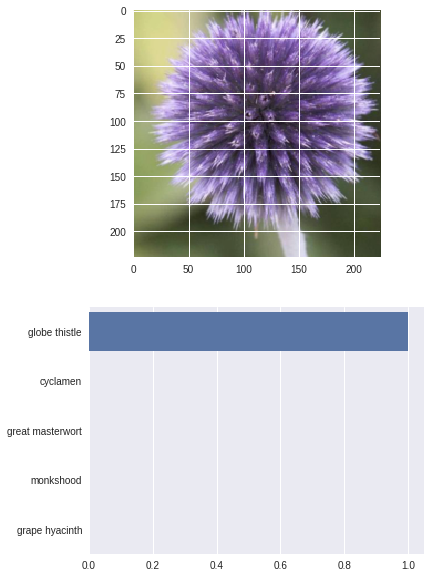

In [0]:
image_path = 'flower_data/train/10/image_07086.jpg'
plot_solution(image_path, model)

##Upload results to airtable

The code below will take your model, test it with the dataset and upload to airtable

In [0]:
!git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
!pip install requests
!pip install airtable
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')

from test_model_pytorch_facebook_challenge import publish_evaluated_model

model = load_checkpoint('/content/drive/My Drive/UdacityPytorchModelSaves/augmented_model2.pth')

publish_evaluated_model(model, input_image_size=224,  username="@Jonathan Hasan", model_name="Resnet152", optim="Adam",
                    criteria="CrossEntropyLoss", scheduler="ReduceLROnPlateau", epoch=45)

fatal: destination path 'deep-learning-flower-identifier' already exists and is not an empty directory.
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Mean accuracy: 0.9915865659713745

Your model performance are now on Airtable: https://airtable.co